# RAG with Knowledge Graphs
This notebook demonstrates how to combine RAG with knowledge graphs for enhanced document understanding and retrieval.

## 1. Install Required Packages

In [2]:
!pip install -qU networkx matplotlib spacy


[notice] A new release of pip is available: 24.0 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


In [3]:
!pip install -qU neo4j  # Optional: for production graph database


ERROR: Invalid requirement: '#'

[notice] A new release of pip is available: 24.0 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


In [4]:
!python -m spacy download en_core_web_sm

     ---------------------------------------- 0.0/12.8 MB ? eta -:--:--
     --------------------------------------- 0.0/12.8 MB 330.3 kB/s eta 0:00:39
     --------------------------------------- 0.1/12.8 MB 656.4 kB/s eta 0:00:20
     --- ------------------------------------ 1.1/12.8 MB 8.6 MB/s eta 0:00:02
     ----------- ---------------------------- 3.8/12.8 MB 22.3 MB/s eta 0:00:01
     ---------------------------- ----------- 9.1/12.8 MB 44.7 MB/s eta 0:00:01
     --------------------------------------  12.8/12.8 MB 93.9 MB/s eta 0:00:01
     --------------------------------------  12.8/12.8 MB 93.9 MB/s eta 0:00:01
     --------------------------------------- 12.8/12.8 MB 59.5 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')



[notice] A new release of pip is available: 24.0 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


In [5]:
# Install required packages
!pip install -qU langchain-openai langchain-community langchain-core langchain-text-splitters


[notice] A new release of pip is available: 24.0 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


In [10]:
!pip install -qU langchain


[notice] A new release of pip is available: 24.0 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


In [11]:
import getpass
import os

if not os.environ.get("OPENAI_API_KEY"):
    os.environ["OPENAI_API_KEY"] = getpass.getpass("Enter API key for OpenAI: ")

from langchain_openai import ChatOpenAI, OpenAIEmbeddings

llm = ChatOpenAI(model="gpt-4o-mini", temperature=0)
embeddings = OpenAIEmbeddings(model="text-embedding-3-large")

## 3. Knowledge Graph Implementation

In [13]:
import networkx as nx
import spacy
from typing import List, Dict, Tuple, Set
from langchain_core.documents import Document
from langchain_core.prompts import PromptTemplate
import json

# Load spaCy model for NER
nlp = spacy.load("en_core_web_sm")

class KnowledgeGraph:
    """Knowledge Graph for storing entities and relationships."""
    
    def __init__(self):
        self.graph = nx.MultiDiGraph()
        self.entity_to_docs = {}  # Maps entities to document IDs
        
    def add_triplet(self, subject: str, predicate: str, object_: str, doc_id: str = None):
        """Add a subject-predicate-object triplet to the graph."""
        self.graph.add_edge(subject, object_, relation=predicate, doc_id=doc_id)
        
        # Track which documents mention these entities
        if doc_id:
            for entity in [subject, object_]:
                if entity not in self.entity_to_docs:
                    self.entity_to_docs[entity] = set()
                self.entity_to_docs[entity].add(doc_id)
    
    def get_neighbors(self, entity: str, depth: int = 1) -> Set[str]:
        """Get neighboring entities up to specified depth."""
        if entity not in self.graph:
            return set()
        
        neighbors = set([entity])
        current_level = {entity}
        
        for _ in range(depth):
            next_level = set()
            for node in current_level:
                # Get both predecessors and successors
                next_level.update(self.graph.predecessors(node))
                next_level.update(self.graph.successors(node))
            neighbors.update(next_level)
            current_level = next_level
        
        return neighbors
    
    def get_related_docs(self, entities: List[str]) -> Set[str]:
        """Get document IDs related to given entities."""
        related_docs = set()
        for entity in entities:
            if entity in self.entity_to_docs:
                related_docs.update(self.entity_to_docs[entity])
        return related_docs
    
    def get_entity_context(self, entity: str) -> str:
        """Get textual context about an entity from the graph."""
        if entity not in self.graph:
            return ""
        
        context_parts = []
        
        # Get outgoing relationships
        for successor in self.graph.successors(entity):
            edges = self.graph.get_edge_data(entity, successor)
            for edge_data in edges.values():
                relation = edge_data.get('relation', 'related_to')
                context_parts.append(f"{entity} {relation} {successor}")
        
        # Get incoming relationships
        for predecessor in self.graph.predecessors(entity):
            edges = self.graph.get_edge_data(predecessor, entity)
            for edge_data in edges.values():
                relation = edge_data.get('relation', 'related_to')
                context_parts.append(f"{predecessor} {relation} {entity}")
        
        return "; ".join(context_parts) if context_parts else ""
    
    def visualize(self, max_nodes: int = 50):
        """Visualize the knowledge graph."""
        import matplotlib.pyplot as plt
        
        # Limit nodes for readability
        if len(self.graph.nodes()) > max_nodes:
            # Get most connected nodes
            degrees = dict(self.graph.degree())
            top_nodes = sorted(degrees, key=degrees.get, reverse=True)[:max_nodes]
            subgraph = self.graph.subgraph(top_nodes)
        else:
            subgraph = self.graph
        
        plt.figure(figsize=(15, 10))
        pos = nx.spring_layout(subgraph, k=0.5, iterations=50)
        
        nx.draw(subgraph, pos, 
                with_labels=True, 
                node_color='lightblue',
                node_size=3000,
                font_size=8,
                font_weight='bold',
                arrows=True,
                edge_color='gray',
                arrowsize=20,
                arrowstyle='->')
        
        plt.title("Knowledge Graph Visualization")
        plt.axis('off')
        plt.tight_layout()
        plt.show()

print("KnowledgeGraph class created successfully!")

KnowledgeGraph class created successfully!


## 4. Entity and Relationship Extraction

In [14]:
class EntityRelationExtractor:
    """Extract entities and relationships from text using LLM and NER."""
    
    def __init__(self, llm):
        self.llm = llm
        self.extraction_prompt = PromptTemplate(
            input_variables=["text"],
            template="""Extract entities and relationships from the following text.
Return a JSON array of triplets in the format: [["subject", "predicate", "object"], ...]

Focus on:
- Key concepts, people, organizations, locations
- Important relationships between entities
- Hierarchical relationships (is-a, part-of)
- Actions and their actors/targets

Text: {text}

JSON (only the array, no additional text):"""
        )
    
    def extract_with_spacy(self, text: str) -> List[Tuple[str, str, str]]:
        """Extract entities using spaCy NER."""
        doc = nlp(text)
        triplets = []
        
        # Extract named entities and create simple relationships
        entities = [(ent.text, ent.label_) for ent in doc.ents]
        
        # Create "mentioned_in" relationships and type relationships
        for ent_text, ent_type in entities:
            triplets.append((ent_text, "is_a", ent_type))
        
        return triplets
    
    def extract_with_llm(self, text: str) -> List[Tuple[str, str, str]]:
        """Extract entities and relationships using LLM."""
        try:
            prompt = self.extraction_prompt.format(text=text[:2000])  # Limit length
            response = self.llm.invoke(prompt)
            
            # Parse JSON response
            content = response.content.strip()
            # Remove markdown code blocks if present
            if content.startswith("```"):
                content = content.split("```")[1]
                if content.startswith("json"):
                    content = content[4:]
            
            triplets_raw = json.loads(content)
            triplets = [(s, p, o) for s, p, o in triplets_raw]
            return triplets
        except Exception as e:
            print(f"LLM extraction error: {e}")
            return []
    
    def extract(self, text: str, use_llm: bool = True) -> List[Tuple[str, str, str]]:
        """Extract entities and relationships using both methods."""
        triplets = self.extract_with_spacy(text)
        
        if use_llm:
            llm_triplets = self.extract_with_llm(text)
            triplets.extend(llm_triplets)
        
        return triplets

print("EntityRelationExtractor class created successfully!")

EntityRelationExtractor class created successfully!


## 5. GraphRAG System

In [15]:
from langchain_core.vectorstores import InMemoryVectorStore
from langchain_text_splitters import RecursiveCharacterTextSplitter

class GraphRAG:
    """Hybrid RAG system combining vector search with knowledge graph."""
    
    def __init__(self, llm, embeddings):
        self.llm = llm
        self.embeddings = embeddings
        self.vector_store = InMemoryVectorStore(embeddings)
        self.knowledge_graph = KnowledgeGraph()
        self.extractor = EntityRelationExtractor(llm)
        self.documents = {}  # Store original documents
        self.text_splitter = RecursiveCharacterTextSplitter(
            chunk_size=1000,
            chunk_overlap=200
        )
    
    def add_documents(self, documents: List[Document], use_llm_extraction: bool = True):
        """Add documents to both vector store and knowledge graph."""
        print(f"Processing {len(documents)} documents...")
        
        # Split documents into chunks
        chunks = self.text_splitter.split_documents(documents)
        
        # Add to vector store
        self.vector_store.add_documents(chunks)
        
        # Extract entities and relationships
        for i, chunk in enumerate(chunks):
            doc_id = f"doc_{i}"
            self.documents[doc_id] = chunk
            
            print(f"Extracting entities from chunk {i+1}/{len(chunks)}...", end='\r')
            
            # Extract triplets
            triplets = self.extractor.extract(chunk.page_content, use_llm=use_llm_extraction)
            
            # Add to knowledge graph
            for subject, predicate, obj in triplets:
                self.knowledge_graph.add_triplet(subject, predicate, obj, doc_id)
        
        print(f"\nProcessed {len(chunks)} chunks. Graph has {len(self.knowledge_graph.graph.nodes())} entities.")
    
    def retrieve(self, query: str, k: int = 4, use_graph: bool = True) -> List[Document]:
        """Hybrid retrieval using vector search and knowledge graph."""
        # Vector search
        vector_results = self.vector_store.similarity_search(query, k=k)
        
        if not use_graph:
            return vector_results
        
        # Extract entities from query
        query_entities = self.extractor.extract_with_spacy(query)
        query_entity_names = set([ent[0] for ent in query_entities])
        
        # Find related entities in graph
        graph_entities = set()
        for entity in query_entity_names:
            graph_entities.update(self.knowledge_graph.get_neighbors(entity, depth=2))
        
        # Get documents related to graph entities
        graph_doc_ids = self.knowledge_graph.get_related_docs(graph_entities)
        graph_results = [self.documents[doc_id] for doc_id in graph_doc_ids if doc_id in self.documents]
        
        # Combine and deduplicate results
        all_results = vector_results + graph_results
        
        # Deduplicate based on content
        seen = set()
        unique_results = []
        for doc in all_results:
            if doc.page_content not in seen:
                seen.add(doc.page_content)
                unique_results.append(doc)
        
        return unique_results[:k*2]  # Return more results due to graph enhancement
    
    def query(self, question: str, use_graph: bool = True) -> Dict[str, any]:
        """Query the GraphRAG system."""
        # Retrieve relevant documents
        retrieved_docs = self.retrieve(question, use_graph=use_graph)
        
        # Extract entities from question for graph context
        question_entities = self.extractor.extract_with_spacy(question)
        entity_names = [ent[0] for ent in question_entities]
        
        # Get graph context for entities
        graph_context = []
        for entity in entity_names:
            context = self.knowledge_graph.get_entity_context(entity)
            if context:
                graph_context.append(context)
        
        # Build enhanced context
        doc_context = "\n\n".join([doc.page_content for doc in retrieved_docs])
        kg_context = "\n".join(graph_context) if graph_context else "No direct graph relationships found."
        
        # Generate answer
        prompt = f"""Answer the question based on the following context:

DOCUMENT CONTEXT:
{doc_context}

KNOWLEDGE GRAPH CONTEXT:
{kg_context}

QUESTION: {question}

Provide a comprehensive answer using both the document context and knowledge graph relationships:"""
        
        response = self.llm.invoke(prompt)
        
        return {
            "answer": response.content,
            "retrieved_docs": retrieved_docs,
            "graph_context": graph_context,
            "entities": entity_names
        }

print("GraphRAG class created successfully!")

GraphRAG class created successfully!


## 6. Load Your Documents
You can load documents from various sources: PDFs, text files, web pages, etc.

In [16]:
from langchain_community.document_loaders import (
    TextLoader,
    PyPDFLoader,
    DirectoryLoader,
    WebBaseLoader
)

# Example 1: Load from text files in a directory
# loader = DirectoryLoader('./documents/', glob="**/*.txt", loader_cls=TextLoader)
# documents = loader.load()

# Example 2: Load a specific PDF
# loader = PyPDFLoader("./your_document.pdf")
# documents = loader.load()

# Example 3: Load from web (we'll use this for demo)
import bs4
loader = WebBaseLoader(
    web_paths=("https://lilianweng.github.io/posts/2023-06-23-agent/",),
    bs_kwargs=dict(
        parse_only=bs4.SoupStrainer(
            class_=("post-content", "post-title", "post-header")
        )
    ),
)
documents = loader.load()

print(f"Loaded {len(documents)} documents")
print(f"First document preview: {documents[0].page_content[:200]}...")

USER_AGENT environment variable not set, consider setting it to identify your requests.


Loaded 1 documents
First document preview: 

      LLM Powered Autonomous Agents
    
Date: June 23, 2023  |  Estimated Reading Time: 31 min  |  Author: Lilian Weng


Building agents with LLM (large language model) as its core controller is a ...


## 7. Initialize GraphRAG and Process Documents

In [17]:
# Initialize GraphRAG system
graph_rag = GraphRAG(llm=llm, embeddings=embeddings)

# Add documents (set use_llm_extraction=False for faster processing with just NER)
# Set to True for better entity extraction but slower processing
graph_rag.add_documents(documents, use_llm_extraction=True)

Processing 1 documents...
Extracting entities from chunk 63/63...
Processed 63 chunks. Graph has 1075 entities.


## 8. Visualize the Knowledge Graph

C:\Users\Edward\AppData\Local\Temp\ipykernel_36160\1530619957.py:108: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


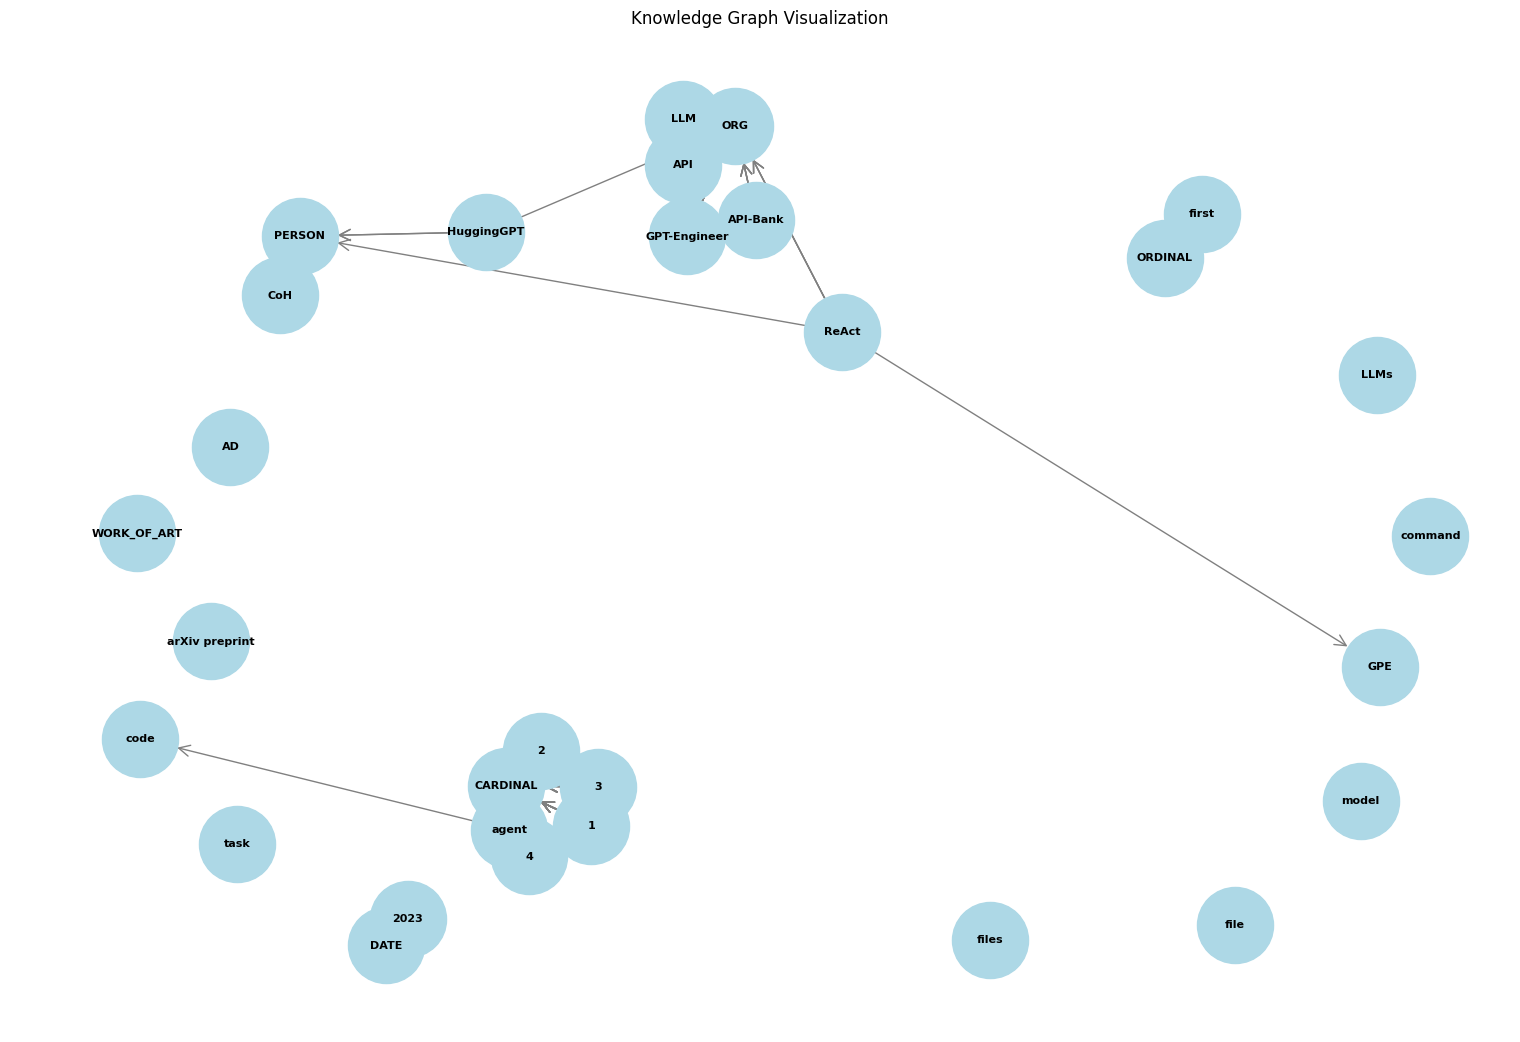

In [18]:
# Visualize the knowledge graph
graph_rag.knowledge_graph.visualize(max_nodes=30)

## 9. Query the GraphRAG System

In [19]:
# Query with graph enhancement
result = graph_rag.query("What is Task Decomposition?", use_graph=True)

print("ANSWER:")
print(result["answer"])
print("\n" + "="*50)
print("\nENTITIES FOUND:", result["entities"])
print("\nGRAPH CONTEXT:")
for ctx in result["graph_context"]:
    print(f"  - {ctx}")
print(f"\nRETRIEVED {len(result['retrieved_docs'])} DOCUMENTS")

ANSWER:
Task Decomposition is a systematic approach to breaking down complex tasks into smaller, more manageable components or steps. This process is essential for effective planning and execution, particularly in scenarios where tasks are intricate and require multiple stages to complete. 

According to the document context, Task Decomposition can be achieved through various methods:

1. **Prompting with LLMs**: Large Language Models (LLMs) can be prompted with simple instructions such as "Steps for XYZ" or "What are the subgoals for achieving XYZ?" to generate a sequence of steps necessary to accomplish a task.

2. **Task-Specific Instructions**: Providing specific instructions tailored to the task at hand, such as "Write a story outline" for creative writing, allows LLMs to understand the context and requirements better.

3. **Human Inputs**: Involving human inputs in the decomposition process can enhance the accuracy and relevance of the task breakdown.

Additionally, the document 

## 10. Compare with Standard RAG

In [20]:
# Query without graph enhancement (standard RAG)
result_standard = graph_rag.query("What is Task Decomposition?", use_graph=False)

print("STANDARD RAG ANSWER:")
print(result_standard["answer"])
print("\n" + "="*50)
print("\nGRAPH-ENHANCED RAG ANSWER:")
print(result["answer"])

STANDARD RAG ANSWER:
Task Decomposition is a systematic approach to breaking down complex tasks into smaller, more manageable components or steps. It is recognized as a product of various methodologies that enhance the efficiency and effectiveness of task execution, particularly in the context of artificial intelligence and large language models (LLMs).

According to the document context, Task Decomposition can be achieved through several methods:

1. **Simple Prompting**: Users can prompt LLMs with straightforward instructions such as "Steps for XYZ" or "What are the subgoals for achieving XYZ?" This method allows the model to generate a list of steps or subgoals necessary to complete a task.

2. **Task-Specific Instructions**: This involves providing explicit instructions tailored to the task at hand, such as "Write a story outline" for creative writing. This method guides the LLM to focus on the specific requirements of the task.

3. **Human Inputs**: Involving human feedback or gui

## 11. Advanced: Query Graph Statistics

In [21]:
kg = graph_rag.knowledge_graph

print(f"Number of entities: {len(kg.graph.nodes())}")
print(f"Number of relationships: {len(kg.graph.edges())}")
print(f"\nMost connected entities:")

degrees = dict(kg.graph.degree())
top_entities = sorted(degrees.items(), key=lambda x: x[1], reverse=True)[:10]

for entity, degree in top_entities:
    print(f"  {entity}: {degree} connections")

Number of entities: 1075
Number of relationships: 1229

Most connected entities:
  ORG: 141 connections
  CARDINAL: 119 connections
  PERSON: 65 connections
  DATE: 56 connections
  LLM: 53 connections
  2023: 41 connections
  agent: 23 connections
  model: 22 connections
  API: 21 connections
  WORK_OF_ART: 15 connections


## 12. Example: Load Your Own Documents

Uncomment and modify the following to use your own documents:

In [ ]:
# # Load your own documents
# from pathlib import Path

# # Option 1: Load from a directory of text files
# # loader = DirectoryLoader('./your_documents/', glob="**/*.txt", loader_cls=TextLoader)

# # Option 2: Load multiple PDFs
# # from langchain_community.document_loaders import PyPDFDirectoryLoader
# # loader = PyPDFDirectoryLoader("./your_pdfs/")

# # Option 3: Load from specific files
# # documents = []
# # for file_path in Path("./your_docs/").glob("*.pdf"):
# #     loader = PyPDFLoader(str(file_path))
# #     documents.extend(loader.load())

# # Load documents
# # my_documents = loader.load()

# # Create a new GraphRAG instance
# # my_graph_rag = GraphRAG(llm=llm, embeddings=embeddings)
# # my_graph_rag.add_documents(my_documents, use_llm_extraction=True)

# # Query your documents
# # result = my_graph_rag.query("Your question here")
# # print(result["answer"])

## Benefits of GraphRAG over Standard RAG:

1. **Better Context Understanding**: Knowledge graphs capture relationships between entities
2. **Multi-hop Reasoning**: Can find connections across multiple documents
3. **Entity-Centric Retrieval**: Retrieve documents based on entity relationships, not just similarity
4. **Explainability**: Graph relationships show why documents were retrieved
5. **Structured Knowledge**: Extract and store structured information from unstructured text